In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from datetime import datetime
import json
import os

from IPython.display import JSON
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import s3fs

os.environ['AWS_PROFILE'] = 'waisman-admin'
sns.set_theme(
    context='paper', style='ticks', palette='muted')


# Load Logs

In [3]:
log_list = [
    # MERFISH
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-2.log',
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-3.log',
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-4.log',  # No replay
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-5.log',  # .5 replay
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-6.log',  # .25 replay - Interesting discovery at beginning
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-7.log',  # No replay, no entropy bonus - trying to lower entropy - maybe next time start at mid entropy with small bonus? Maybe multiply entropy grad by some value to simulate higher lr? Current vel pen might be harsh, too
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-8.log',  # Same but with action_std lr 3e-3
    # 's3://nkalafut-celltrip/logs/3gpu-2learn-6run-100iter-9.log',  # Same but with action_std lr 1e-1
    # 's3://nkalafut-celltrip/logs/5gpu-2learn-5run-100iter-10.log',  # Add entropy bonus, use KL targeting rather than ES (VERY GOOD)
    # 's3://nkalafut-celltrip/logs/5gpu-Replay.log',  # Replay, change beta inc., imputation
    # 's3://nkalafut-celltrip/logs/5gpu-Replay-2.log',  # Change beta inc. strategy
    # 's3://nkalafut-celltrip/logs/5gpu-Replay-3.log',  # Change replay
    # 's3://nkalafut-celltrip/logs/2gpu-NoReplay.log',  # Change replay  (VERY GOOD)
    # 's3://nkalafut-celltrip/logs/3gpu-9k-ExtraKL.log',  # 9K samples and .03 -> .1 target KL  (MUCH FASTER!)
    # 's3://nkalafut-celltrip/logs/3gpu-9k-ExtraKL-2.log',  # Longer run of previous
    # 's3://nkalafut-celltrip/logs/3gpu-9k-ExtraKL-DontSync.log',  # Same but don't sync across nodes
    # 's3://nkalafut-celltrip/logs/3gpu-1k.log',  # Same but 1k cells
    # 's3://nkalafut-celltrip/logs/3gpu-1k-cont.log',
    # 's3://nkalafut-celltrip/logs/3gpu-new.log',  # New params
    # 's3://nkalafut-celltrip/logs/3gpu-new-lite.log',  # Lite
    # 's3://nkalafut-celltrip/logs/3gpu-new-arch.log',  # New shared architecture - not anymore
    # 's3://nkalafut-celltrip/logs/3gpu-new-arch-2.log',  # All new, same as last but hyperparam changes to prevent ASTD blowing up
    # 's3://nkalafut-celltrip/logs/3gpu-new-arch-3.log',  # Better return normalization
    # 's3://nkalafut-celltrip/logs/3gpu-new-arch-3-2k.log',  # 2k cells
    # 's3://nkalafut-celltrip/logs/3gpu-new-arch-10.log',  # Amazing! But still not imputing right
    # 's3://nkalafut-celltrip/logs/3gpu-new-arch-10-static.log',  # w/o random sampling, on whole dataset - if fails, try raising entropy coeff
    # 's3://nkalafut-celltrip/logs/3gpu-new-arch-10-norms.log',  # Norms and tanh plus entropy
    # 's3://nkalafut-celltrip/logs/3gpu-new-arch-10-norms-log.log',  # Log scale env reward (BEST SO FAR, SEPARATES)
    # 's3://nkalafut-celltrip/logs/Retuned-Vel.log',  # Relative velocity reward
    # 's3://nkalafut-celltrip/logs/Retuned-Vel-NoLR.log',  # Add epsilons, log velocity reward, normalized initial reward dist, no lr decay
    # 's3://nkalafut-celltrip/logs/Retuned-Vel-NoLR5.log',  # 3e-4 decayed with .99
    # 's3://nkalafut-celltrip/logs/Retuned-Vel-NowLR.log',  # 3e-4 decayed with .97 (CRASHED)
    # 's3://nkalafut-celltrip/logs/Retuned-Vel-NowLR2.log',  # Same but with 1000 env timesteps, more complicated model
    # 's3://nkalafut-celltrip/logs/Higher-Entropy.log',  # Back to smaller model, but with no entropy loss
    # 's3://nkalafut-celltrip/logs/Zero-Init.log',  # Zero initialization for env
    # 's3://nkalafut-celltrip/logs/Huge-Batch.log',  # 100k batch
    # 's3://nkalafut-celltrip/logs/Huge-Batch-Fix.log',  # Huge batch fixed env dist (SUCCESS!)
    # 's3://nkalafut-celltrip/logs/PCA.log',  # Same but with PCA
    # 's3://nkalafut-celltrip/logs/PopArt.log',
    # 's3://nkalafut-celltrip/logs/Partial.log',  # Segmented episodes - like traditional PPO but all truncated
    # 's3://nkalafut-celltrip/logs/Partial-2.log',  # Same but with train-val
    # 's3://nkalafut-celltrip/logs/Partial-2-cont.log',
    # 's3://nkalafut-celltrip/logs/Partial-L2.log',  # Same but with L2 reg 1e-3
    # 's3://nkalafut-celltrip/logs/Partial-L2-VelLinear.log',  # Same but with linear vel penalty
    # 's3://nkalafut-celltrip/logs/Partial-L2-VelLinear-ClampLog.log',  # Clamped log prob to avoid NAN
    # 's3://nkalafut-celltrip/logs/Partial-L2-VelLinear-ClampLog-Gamma1.log',  # Continued with gamma=1
    # 's3://nkalafut-celltrip/logs/Noise.log',  # Add Noise with STD .1 and readd PopArt return normalization, and only one update iter
    # 's3://nkalafut-celltrip/logs/Noise-Reg.log',  # Same but with L2 regularization, annealing, proper Adam, Advantage clipping
    # 's3://nkalafut-celltrip/logs/Noise-Both.log',  # Same but with ~LR/10~, return STD beta*10, ~add noise to calc dist~, NEXT TIME clamp log std
    # 's3://nkalafut-celltrip/logs/Noise-Over.log',  # With Noise .01, (WORKS, BUT FAILED WITH HIGH KL AND DOESN'T GENERALIZE WELL)
    # 's3://nkalafut-celltrip/logs/doubled.log',  # Doubled model with no noise and independent critic
    # 's3://nkalafut-celltrip/logs/scglue.log',  # same on scGLUE dataset
    's3://nkalafut-celltrip/logs/doubled-allloss.log',  # All losses
    # TODO: Maybe multiply by inverse group origin in env
    # TODO: Implement env offset for multiple GPU case
    # TODO: Save best checkpoint on s3 always, then just use that
    # NOTE: It appears failure is a form of representation collapse caused by dead neurons, maybe reinitialize or use PFO
    # NOTE: Be aware of double-descent (https://openai.com/index/deep-double-descent/)
]


In [4]:
s3 = s3fs.S3FileSystem()
def convert_json(s):
    s = s.replace('\'', '"').replace('False', 'false').replace('True', 'true')
    s_json = json.loads(s)
    try: s_json['Timestamp'] = datetime.strptime(s_json['Timestamp'], '%Y-%m-%d %H:%M:%S.%f')  # Convert to datetime
    except: s_json['Timestamp'] = datetime.strptime(s_json['Timestamp'], '%Y-%m-%d %H:%M:%S')
    return s_json
record_lists = []
for fname in log_list:
    record_lists.append([])
    if fname.startswith('s3://'): handle = s3.open(fname, 'r')
    else: handle = open(fname, 'r')
    with handle as f: record_lists[-1] += [convert_json(record) for record in f.read().split('\n') if len(record) > 0]
assert np.array([len(records) > 3 for records in record_lists]).all(), 'Logfile(s) is empty! If currently running, try waiting for flush'


In [5]:
# Generate df
df_record_lists = [pd.DataFrame(records) for records in record_lists]
for i in range(len(df_record_lists)):
    # Document log ID
    df_record_lists[i]['Log ID'] = i
    # Explode dictionaries
    for col in ('Itemized Reward', 'Losses', 'Statistics'):
        try: df_record_lists[i] = pd.concat((df_record_lists[i].drop(columns=col), pd.json_normalize(df_record_lists[i][col])), axis=1)
        except: print(f'Column {col} not found, might be missing some event types. '
                    f'This is expected if running early in training.')
    # Prune previous logfile
    if i > 0:
        first_policy = df_record_lists[i]['Policy Iteration'].min()
        df_record_lists[i-1] = df_record_lists[i-1].loc[df_record_lists[i-1]['Policy Iteration'] <= first_policy]
        df_record_lists[i-1] = df_record_lists[i-1].loc[~((df_record_lists[i-1]['Policy Iteration'] == first_policy) * (df_record_lists[i-1]['Event Type'] == 'Rollout'))]
    # Adjust to beginning timing
    begin_time = df_record_lists[i].loc[df_record_lists[i]['Event Type']=='Register Workers', 'Timestamp'].iloc[0]
    end_time = df_record_lists[i-1].iloc[-1]['Timestamp'] * timestamp_divisor + df_record_lists[i].iloc[-1]['Time'] if i > 0 else 0
    timestamp_divisor = 60**1  # Minutes
    df_record_lists[i]['Timestamp'] = df_record_lists[i]['Timestamp'].apply(lambda t: (end_time + (t-begin_time).total_seconds()) / timestamp_divisor)
    end_time = df_record_lists[i].iloc[-1]['Timestamp'] * timestamp_divisor + df_record_lists[i].iloc[-1]['Time']
df_records = pd.concat(df_record_lists)

# Get spans
from collections import defaultdict
span_dict = defaultdict(lambda: [])
for _, r in df_records.iterrows():
    span_dict[r['Event Type']].append(
        (r['Timestamp']-(r['Time'] if r['Time'] is not None else 0)/timestamp_divisor, r['Timestamp']))
    
# Squash span dict
span_dict_squashed = {}
for k in span_dict:
    squashed = []
    for v1 in span_dict[k]:
        i = 0
        while i < len(squashed):
            v2 = squashed[i]
            if v1[0] < v2[1] and v2[0] < v1[1]:
                # Repropagate with combined span
                squashed.pop(i)
                v1 = (min(v1[0], v2[0]), max(v1[1], v2[1]))
                i = 0
                continue
            i += 1
        squashed.append(v1)
    span_dict_squashed[k] = squashed


In [6]:
# Event filter
def event_filter(df, event_type):
    return (df
        .loc[df['Event Type'] == event_type]
        .dropna(axis=1)
        .drop(columns=['Event Type']))

def group_policy(df, agg='mean'):
    df = df.drop(columns=['Rank']).groupby('Policy Iteration')
    if agg == 'mean': df = df.mean()
    elif agg == 'min': df = df.min()
    elif agg == 'max': df = df.max()
    elif agg == 'std': df = df.std()
    return df.reset_index()


In [7]:
# group_policy(event_filter(df_records, 'Rollout'))


In [8]:
# group_policy(event_filter(df_records, 'Update'))


# Runtime Parameters

In [9]:
# Register colors
reward_colors = {
    'total': 'black', 'distance': 'darkturquoise',
    'origin': 'darkgreen', 'bound': 'red',
    'velocity': 'orange', 'action': 'gold'}
event_colors = {
    'Rollout': 'lightcoral', 'Update': 'paleturquoise',
    'Send Memory': 'khaki', 'Receive Memories': 'burlywood',
    'Synchronize Policy': 'darkseagreen',
    'Save Checkpoint': 'brown', 'Load Checkpoint': 'brown',
    'Other': 'brown'}


# Loss Plot

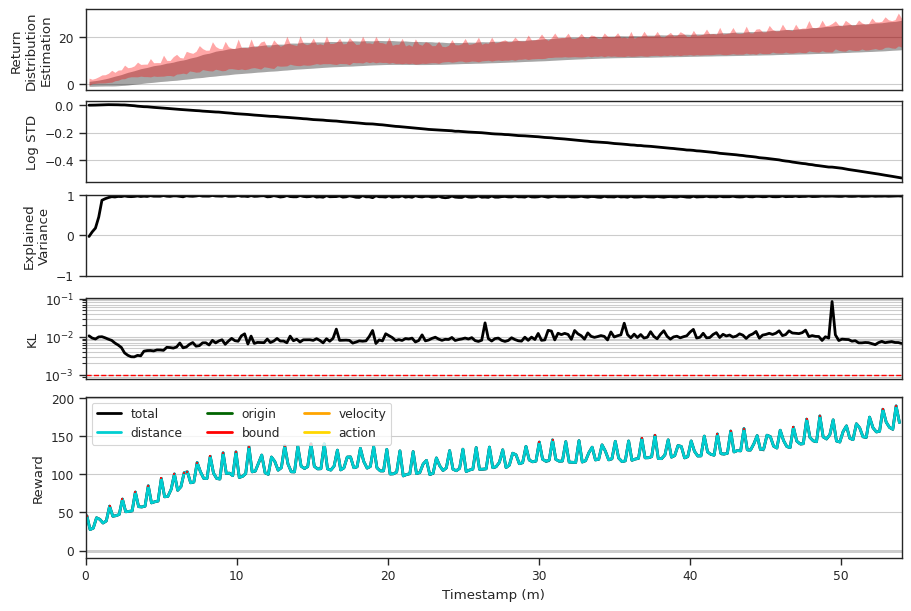

In [10]:
# Parameters
use_smooth = False
only_ends = False
omit_zero = True
symlog = False
linthresh = (1e1 if use_smooth else 1e-1)  # * 1e1

# Melt functions
def melt_rewards_rollout(df):
    df = df[[
        'Timestamp', 'Reward', 'distance', 'origin',
        'bound', 'velocity', 'action']].rename(
            columns={'Reward': 'total'}
        ).melt(
            id_vars='Timestamp', var_name='Reward',
            value_name='Value')
    return df

def melt_rewards_update(df):
    df = df[[
        'Timestamp', 'Iterations', 'Log STD', 'PPO',
        'critic', 'entropy', 'KL']].melt(
            id_vars='Timestamp', var_name='Parameter',
            value_name='Value')
    return df

# Filter function
def filter_zero(df):
    df.loc[df['Value'] == 0, 'Value'] = pd.NA
    return df
if not omit_zero: filter_zero = lambda x: x

def smooth(df_col, episode_len=1_000, sample_len=1_000):
    # Replace NAN with zero
    df_col = df_col.fillna(0)
    # Mean episode reward
    # num_runners = df_rollout['Rank'].unique().shape[0]
    # df_rollout[['Reward']].rolling(int(num_runners*episode_len/timesteps_per_rollout)).sum() / num_runners
    timesteps_per_rollout = df_rollout['Timesteps'].iloc[0]
    window = int(sample_len/timesteps_per_rollout)
    rolling_sum = df_col.rolling(window).sum() * episode_len / (window * timesteps_per_rollout)
    # Only show full episodes
    if only_ends:
        for i in range(0, rolling_sum.shape[0], window):
            rolling_sum.iloc[i:i+window] = rolling_sum.iloc[min(i+window-1, rolling_sum.shape[0]-1)]
    # Replace zeros with NAN
    if omit_zero: rolling_sum.loc[rolling_sum == 0] = pd.NA
    return rolling_sum
if not use_smooth: smooth = lambda x: x

# Line plot function
def gap_plot(df, x, y, hue, palette, ax, legend=True, plot_type='line', **kwargs):
    # sns.lineplot(
    #     melt_rewards(group_policy(event_filter('Rollout'))),
    #     x='Timestamp', y='Value', hue='Reward', palette=reward_colors,
    #     lw=2, ax=ax)
    for h in df[hue].unique():
        df_filt = df.loc[df[hue]==h]
        smoothed_y = smooth(df_filt[y])
        if plot_type == 'line':
            ax.plot(df_filt[x], smoothed_y, color=palette[h], label=h if legend else None, **kwargs)
            # Plot new best
            new_best = np.zeros_like(df_filt[y].to_numpy(), dtype=bool); best = -np.inf
            for i, v in enumerate(smoothed_y.to_numpy()):
                if v > best: best = v; new_best[i] = True
            ax.scatter(df_filt.loc[new_best, x], smoothed_y.loc[new_best], marker='|', s=4, color='red', zorder=2)
        elif plot_type == 'scatter':
            ax.scatter(df_filt[x], smoothed_y, color=palette[h], label=h if legend else None, **kwargs)

# Data
df_raw = melt_rewards_rollout(event_filter(df_records, 'Rollout'))
df_mean = melt_rewards_rollout(group_policy(event_filter(df_records, 'Rollout'), agg='mean'))
df_std = melt_rewards_rollout(group_policy(event_filter(df_records, 'Rollout'), agg='std'))
df_min = melt_rewards_rollout(group_policy(event_filter(df_records, 'Rollout'), agg='min'))
df_max = melt_rewards_rollout(group_policy(event_filter(df_records, 'Rollout'), agg='max'))
df_rollout = event_filter(df_records, 'Rollout')
df_update = group_policy(event_filter(df_records, 'Update'), agg='mean')

# Plot
fig = plt.figure(figsize=(9, 6), layout='constrained')
ax_loss = plt.subplot2grid((6, 2), (4, 0), 2, 2, fig)
ax_kl = plt.subplot2grid((6, 2), (3, 0), 1, 2, fig, sharex=ax_loss)
ax_ev = plt.subplot2grid((6, 2), (2, 0), 1, 2, fig, sharex=ax_loss)
ax_entrop = plt.subplot2grid((6, 2), (1, 0), 1, 2, fig, sharex=ax_loss)
ax_moving = plt.subplot2grid((6, 2), (0, 0), 1, 2, fig, sharex=ax_loss)
# TODO: Maybe try timesteps on x?

# Moving returns
ax_moving.fill_between(
        df_update['Timestamp'],
        df_update['Moving Return Mean']-df_update['Moving Return STD'],
        df_update['Moving Return Mean']+df_update['Moving Return STD'], lw=0, color='black', alpha=.35)
ax_moving.fill_between(
        df_update['Timestamp'],
        df_update['Return Mean']-df_update['Return STD'],
        df_update['Return Mean']+df_update['Return STD'], lw=0, color='red', alpha=.35)
ax_moving.set_ylabel('Return\nDistribution\nEstimation')
ax_moving.grid(axis='y', which='both', visible=True)
ax_moving.tick_params(axis='x', which='both', bottom=False)
plt.setp(ax_moving.get_xticklabels(), visible=False)
# if symlog:
#     ax_moving.set_yscale('symlog', base=10, linthresh=linthresh)
#     for s in (-1, 1): ax_moving.axhline(y=s*linthresh, color='black', lw=1, ls='--', zorder=.2)

# Entropy
ax_entrop.plot(
    df_update['Timestamp'], df_update['Log STD'], lw=2, color='black')
ax_entrop.set_ylabel('Log STD')
ax_entrop.grid(axis='y', which='both', visible=True)
ax_entrop.tick_params(axis='x', which='both', bottom=False)
plt.setp(ax_entrop.get_xticklabels(), visible=False)

# Explained Variance
ax_ev.plot(
    df_update['Timestamp'], df_update['Explained Variance'], lw=2, color='black')
ax_ev.set_ylabel('Explained\nVariance')
ax_ev.grid(axis='y', which='both', visible=True)
ax_ev.tick_params(axis='x', which='both', bottom=False)
plt.setp(ax_ev.get_xticklabels(), visible=False)
ax_ev.set_ylim(-1, 1)

# KL
df_update = group_policy(event_filter(df_records, 'Update'), agg='mean')
ax_kl.plot(
    df_update['Timestamp'], df_update['KL'], lw=2, color='black')
# kl_target = .3
# ax_kl.axhline(y=kl_target*1.5, ls='--', lw=1, color='black')
# ax_kl.axhline(y=kl_target/1.5, ls='--', lw=1, color='black')
ax_kl.set_yscale('log')
ax_kl.set_ylabel('KL')
ax_kl.grid(axis='y', which='both', visible=True)
ax_kl.tick_params(axis='x', which='both', bottom=False)
plt.setp(ax_kl.get_xticklabels(), visible=False)
# ax_kl.tick_params(axis='x', which='both', bottom=False)

# Shading
for h in df_raw['Reward'].unique():
    mask = df_min['Reward'] == h
    # Max min
    x = df_mean.loc[mask, 'Timestamp']
    # lower, upper = df_min.loc[mask, 'Value'], df_max.loc[mask, 'Value']  # Max min
    lower, upper = (
        smooth(df_mean.loc[mask, 'Value']
        - 1.96*df_std.loc[mask, 'Value']),
        smooth(df_mean.loc[mask, 'Value']
        + 1.96*df_std.loc[mask, 'Value']))  # STD
    # Filter zeros
    zero_mask = (lower == 0) * (upper == 0)
    lower[zero_mask] = upper[zero_mask] = pd.NA
    # Fill
    ax_loss.fill_between(
        x, lower, upper, lw=0, color=reward_colors[h], alpha=.35)
# Mean line
gap_plot(
    filter_zero(df_mean), x='Timestamp', y='Value', hue='Reward',
    palette=reward_colors, lw=2, ax=ax_loss, plot_type='line')
# Stages
for i, r in event_filter(df_records, 'Advance Stage').iterrows():
    ax_loss.axvline(r['Timestamp'], color='black', ls=':', lw=2, zorder=.2)
# Formatting
# sns.despine(ax=ax_loss)
ax_loss.set(xlabel='Timestamp (m)', ylabel='Reward')
ax_loss.set_xlim(left=0, right=np.max([span_dict_squashed[k][-1][1] for k in span_dict]))
if symlog:
    ax_loss.set_yscale('symlog', base=10, linthresh=linthresh)
    for s in (-1, 1): ax_loss.axhline(y=s*linthresh, color='black', lw=1, ls='--', zorder=.2)
ax_loss.axhline(y=0, color='black', lw=1, ls='-', zorder=.2)
# for k in span_dict_squashed.keys():
#     if k not in event_colors: continue
#     for xmin, xmax in span_dict_squashed[k]: ax_loss.axvspan(xmin, xmax, color=event_colors[k], alpha=.3, lw=0, zorder=.1)
ax_loss.grid(axis='y', which='both', visible=True)
ax_loss.legend(loc='upper left', ncols=3)

# Early stopping based on KL (MAYBE DO BASED ON LOG STD, KL, AND RWD?)
count = 0; es_timestep = None; lapses = 5; es_threshold = 1e-3; min_updates = 500
for i, r in group_policy(event_filter(df_records, 'Update')).iterrows():
    if i < min_updates: continue
    count = count + 1 if r['KL'] < es_threshold else 0
    if count >= lapses:
        es_timestep = r['Timestamp']
        break
if es_timestep is not None: ax_loss.axvline(x=es_timestep, ls=':', color='red')
ax_kl.axhline(y=es_threshold, ls='--', lw=1, color='red')

# Display
# ax1.axhline(y=.03)
fig.show()


In [11]:
try:
    num_iters = df_mean.loc[df_mean['Reward']=='total', 'Value'].shape[0]
    smoothed = smooth(df_mean.loc[df_mean['Reward']=='total', 'Value']).dropna()
    smoothed_dist = smooth(df_mean.loc[df_mean['Reward']=='distance', 'Value']).dropna()
    best_iter = smoothed.index[smoothed.argmax()]
    best_score = smoothed.loc[best_iter]
    print(f'Best iteration {best_iter}/{num_iters} ({best_score:.2f})')
except: pass


Best iteration 246/248 (189.61)


# Time Plot

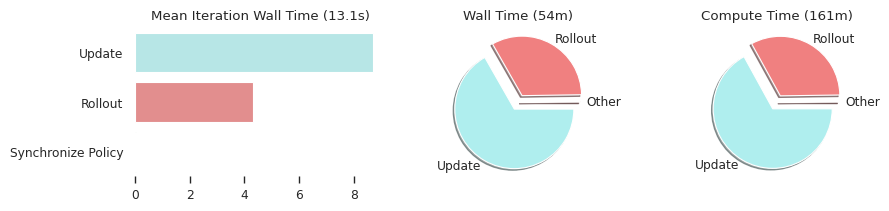

In [12]:
# Processing functions
def group_small(df):
    mask = (df['Time'] / df['Time'].sum()) < .02
    if mask.sum() > 0:
        other_row = df.loc[mask].sum()
        df = df.loc[~mask].copy()
        df.loc['Other'] = other_row
    return df

# Get times
span_times = {k: timestamp_divisor*np.sum([v2[1]-v2[0] for v2 in v1]) for k, v1 in span_dict_squashed.items()}
df_walltime = pd.DataFrame(span_times.values(), index=span_times.keys(), columns=['Time'])
df_walltime.index.name = 'Event Type'
df_walltime = df_walltime.loc[df_walltime['Time'] != 0].dropna()
df_walltime['Mean Time'] = df_walltime.apply(lambda r: r['Time'] / len(span_dict_squashed[r.name]), axis=1)
df_walltime['Iteration Time'] = df_walltime.apply(lambda r: r['Time'] / len(span_dict_squashed['Update']), axis=1)
df_comptime = df_records.groupby('Event Type').sum()[['Time']]
df_comptime = df_comptime.loc[df_comptime['Time'] != 0].dropna()
df_comptime['Mean Time'] = df_comptime.apply(lambda r: r['Time'] / len(span_dict_squashed[r.name]), axis=1)
df_comptime['Iteration Time'] = df_comptime.apply(lambda r: r['Time'] / len(span_dict_squashed['Update']), axis=1)

# Plot function
def plot_pie(df, ax):
    labels = df.index.to_numpy()
    sizes = df['Time'].to_numpy()
    colors = [event_colors[l] for l in labels]
    explode = .3 * np.log(1+sizes) / np.log(1+sizes).sum()
    # explode = np.zeros_like(sizes)
    # explode[np.argsort(sizes).flatten()[-2:]] = .1
    ax.pie(
        sizes, explode=explode, labels=labels, colors=colors,  # autopct='%1.1f%%',
        shadow=True, startangle=0, counterclock=False, rotatelabels=False)

# Plot
fig = plt.figure(figsize=(9, 2), layout='constrained')
ax1 = plt.subplot2grid((1, 3), (0, 1), 1, 1, fig=fig)
plot_pie(group_small(df_walltime.sort_values('Time', ascending=False)), ax1)
ax1.set(title=f'Wall Time ({df_walltime.sum()["Time"]/60:.0f}m)')
ax2 = plt.subplot2grid((1, 3), (0, 2), 1, 1, fig=fig)
plot_pie(group_small(df_comptime.sort_values('Time', ascending=False)), ax2)
ax2.set(title=f'Compute Time ({df_comptime.sum()["Time"]/60:.0f}m)')
ax3 = plt.subplot2grid((1, 3), (0, 0), 1, 1, fig=fig)
sns.barplot(
    df_walltime.sort_values('Iteration Time', ascending=False), y='Event Type', x='Iteration Time', hue='Event Type',
    palette=event_colors, ax=ax3)
sns.despine(left=True, bottom=True, ax=ax3)
ax3.set(title=f'Mean Iteration Wall Time ({df_walltime.sum()["Iteration Time"]:.1f}s)', xlabel=None, ylabel=None)
ax3.tick_params(axis='y', which='major', left=False)
# ax3.set_yticks([])
fig.show()


In [13]:
# # Format
# df_rollout = group_policy(event_filter(df_records, 'Rollout'), agg='mean')
# df_update = group_policy(event_filter(df_records, 'Update'), agg='mean')
# df_combined = df_rollout.join(df_update, rsuffix='_update')

# # Plot
# fig = plt.figure(figsize=(6, 6), layout='constrained')
# ax1 = plt.subplot2grid((1, 1), (0, 0), 1, 1, fig=fig)
# sns.scatterplot(df_combined, x='Log STD', y='distance', hue='Timestamp', ax=ax1)
# ax1.set_yscale('symlog')
# ax1.invert_xaxis()
# fig.show()
